In [1]:
# https://keras.io/examples/vision/handwriting_recognition
# https://keras.io/examples/vision/captcha_ocr
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Import the dataset

In [4]:
from dataset_handler import create_dataset, remove_rare_chars
DATASET_DIR = r'../../Dataset/trdg'
LABELS_PATH = r'../../Dataset/trdg/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters 

In [5]:
img_paths, labels, vocabs = create_dataset(DATASET_DIR, LABELS_PATH, sim2tra=True)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=3)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs, sep='')

Number of images found: 2942
Number of labels found: 2942
Number of unique characters: 1684
Characters present:{'㐌': 316, '浪': 300, '朱': 247, '\U000f047c': 214, '\U000f070b': 213, '尼': 210, '吏': 200, '𦋦': 197, '𢚸': 197, '娘': 197, '𠊛': 192, '固': 189, '拱': 172, '之': 167, '情': 161, '埃': 161, '買': 151, '芇': 146, '𠬠': 145, '衝': 143, '仙': 139, '欺': 138, '羣': 136, '𠳒': 136, '別': 135, '麻': 130, '𠓨': 127, '𧗱': 124, '爫': 122, '塘': 117, '花': 114, '𠫾': 109, '𠄩': 108, '払': 106, '渚': 106, '𡗶': 106, '浽': 104, '傷': 103, '雲': 102, '強': 102, '吶': 101, '渃': 99, '𦖑': 99, '饒': 97, '庒': 97, '如': 96, '些': 95, '分': 94, '畧': 93, '咍': 92, '鐄': 90, '時': 90, '昆': 90, '低': 90, '𢬣': 89, '𡢐': 88, '於': 88, '身': 87, '兜': 87, '𧡊': 86, '細': 84, '生': 81, '月': 79, '公': 78, '戈': 78, '皮': 78, '調': 76, '﨤': 74, '𣈜': 74, '爲': 73, '茹': 73, '沛': 73, '牢': 73, '仍': 73, '油': 73, '命': 72, '排': 70, '典': 66, '包': 66, '娥': 65, '碎': 65, '㗂': 64, '\U000f061a': 63, '𠁀': 61, '\U000f02c7': 61, '恩': 61, '迻': 59, '耒': 59, '茄': 57, '共': 57, '

## Visualize the data

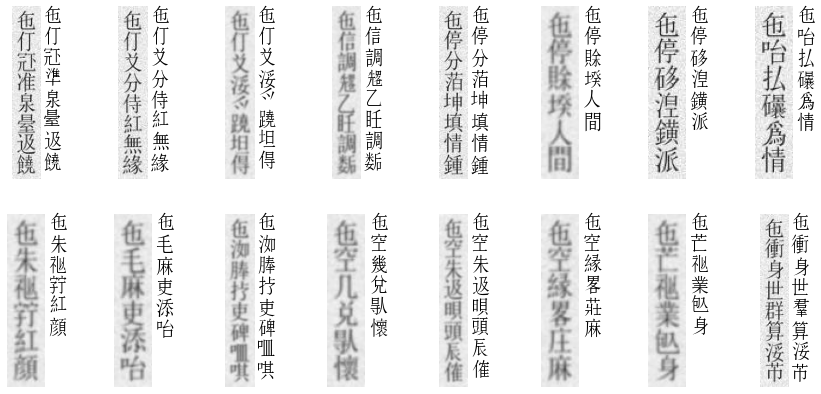

In [6]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

# Define the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU
from cnn import custom_cnn, get_imagenet_model, reshape_for_cnn
from ctc import CTCLayer

In [9]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')
    
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing the output to the RNN
    x = reshape_for_cnn(x, dim_to_keep=-1)

    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.2,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char2num.vocabulary_size() + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)

    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    return model

In [10]:
## Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_model.summary(line_length=100)

In [11]:
# imagenet_output_layer = 'block4_pool'
# model = build_crnn(imagenet_model, imagenet_output_layer)
model = build_crnn()
model.summary(line_length=100)

Model: "CRNN"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                             

# Training

In [12]:
from dataset_handler import process_one_image
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char2num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

## Data input pipeline

In [13]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = process_one_image(img_path, img_size)
    label = char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

In [14]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

## Callbacks

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

def scheduler(epoch, lr):
    if epoch == 0 or (epoch % 10) > 0: return lr # Keeps lr for 10 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [16]:
from kfold import kfold_decorator
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [17]:
@kfold_decorator(n_splits=10, random_state=2022)
def train(model, img_paths, labels, train_idx=None, valid_idx=None):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
    edit_distance_callback = EditDistanceCallback(Model(
        inputs = model.get_layer('image').input, 
        outputs = model.get_layer('rnn_output').output
    ), valid_tf_dataset, MAX_LENGTH)
    
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = EPOCHS,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
            edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    return (
        valid_tf_dataset, 
        early_stopping_callback.best_epoch, 
        edit_distance_callback.logs,
        history,
    )

In [18]:
%%time
valid_datasets, best_epochs, edist_logs, histories, models = train(model, img_paths, labels)

Start training for Fold 01:
Epoch 1/100
166/166 [==============================] - 15s 49ms/step - loss: 50.9971 - val_loss: 54.1051 - lr: 2.0000e-04
Epoch 2/100
166/166 [==============================] - 5s 33ms/step - loss: 44.6918 - val_loss: 46.4681 - lr: 2.0000e-04
Epoch 3/100
166/166 [==============================] - 6s 34ms/step - loss: 39.3659 - val_loss: 41.0020 - lr: 2.0000e-04
Epoch 4/100
166/166 [==============================] - 5s 32ms/step - loss: 29.3801 - val_loss: 26.0605 - lr: 2.0000e-04
Epoch 5/100
166/166 [==============================] - 5s 33ms/step - loss: 17.2875 - val_loss: 17.1662 - lr: 2.0000e-04
Epoch 6/100
166/166 [==============================] - 5s 33ms/step - loss: 9.8019 - val_loss: 13.0233 - lr: 2.0000e-04
Epoch 7/100
166/166 [==============================] - 5s 32ms/step - loss: 5.5731 - val_loss: 12.7568 - lr: 2.0000e-04
Epoch 8/100
166/166 [==============================] - 5s 33ms/step - loss: 3.2124 - val_loss: 9.1938 - lr: 2.0000e-04
Epoch 9

165/166 [============================>.] - ETA: 0s - loss: 0.0153
Epoch 38: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
 - Mean edit distance: 1.7988721
166/166 [==============================] - 5s 32ms/step - loss: 0.0153 - val_loss: 3.5757 - lr: 1.0000e-04
Epoch 39/100
166/166 [==============================] - 6s 36ms/step - loss: 0.0152 - val_loss: 3.5199 - lr: 5.0000e-05
Epoch 40/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0146 - val_loss: 3.5290 - lr: 5.0000e-05
Epoch 41/100
166/166 [==============================] - 6s 34ms/step - loss: 0.0142 - val_loss: 3.5163 - lr: 5.0000e-05
Epoch 42/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0137 - val_loss: 3.5052 - lr: 5.0000e-05
Epoch 43/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0132 - val_loss: 3.4983 - lr: 5.0000e-05
Epoch 44/100
166/166 [==============================] - 6s 34ms/step - loss: 0.0128 - val_loss: 3.5054 - lr: 5.0000e-

Epoch 10: early stopping
Finish training for Fold 03

Start training for Fold 04:
Epoch 1/100
166/166 [==============================] - 12s 44ms/step - loss: 50.8068 - val_loss: 51.8907 - lr: 2.0000e-04
Epoch 2/100
166/166 [==============================] - 5s 32ms/step - loss: 44.8214 - val_loss: 49.1048 - lr: 2.0000e-04
Epoch 3/100
166/166 [==============================] - 5s 33ms/step - loss: 40.1939 - val_loss: 44.9464 - lr: 2.0000e-04
Epoch 4/100
166/166 [==============================] - 5s 32ms/step - loss: 34.7114 - val_loss: 40.6669 - lr: 2.0000e-04
Epoch 5/100
166/166 [==============================] - 5s 32ms/step - loss: 28.7707 - val_loss: 38.2033 - lr: 2.0000e-04
Epoch 6/100
166/166 [==============================] - 5s 32ms/step - loss: 23.0473 - val_loss: 36.1709 - lr: 2.0000e-04
Epoch 7/100
166/166 [==============================] - 5s 32ms/step - loss: 18.0594 - val_loss: 36.6555 - lr: 2.0000e-04
Epoch 8/100
166/166 [==============================] - 5s 32ms/step - 

Epoch 16/100
166/166 [==============================] - 5s 33ms/step - loss: 0.1110 - val_loss: 3.4126 - lr: 2.0000e-04
Epoch 17/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0937 - val_loss: 3.3212 - lr: 2.0000e-04
Epoch 18/100
166/166 [==============================] - 6s 33ms/step - loss: 0.0797 - val_loss: 3.3050 - lr: 2.0000e-04
Epoch 19/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0689 - val_loss: 3.2435 - lr: 2.0000e-04
Epoch 20/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0599 - val_loss: 3.1865 - lr: 2.0000e-04
Epoch 21/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0528 - val_loss: 3.1521 - lr: 2.0000e-04
Epoch 22/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0467 - val_loss: 3.1248 - lr: 2.0000e-04
Epoch 23/100
166/166 [==============================] - 6s 33ms/step - loss: 0.0414 - val_loss: 3.0870 - lr: 2.0000e-04
Epoch 24/100
166/166 [==================

Epoch 6/100
166/166 [==============================] - 6s 35ms/step - loss: 25.3599 - val_loss: 34.3304 - lr: 2.0000e-04
Epoch 7/100
166/166 [==============================] - 5s 33ms/step - loss: 20.3944 - val_loss: 36.1287 - lr: 2.0000e-04
Epoch 8/100
164/166 [============================>.] - ETA: 0s - loss: 16.1636
Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 7.131579
166/166 [==============================] - 5s 33ms/step - loss: 16.1563 - val_loss: 34.9170 - lr: 2.0000e-04
Epoch 9/100
166/166 [==============================] - 5s 33ms/step - loss: 11.8646 - val_loss: 28.1490 - lr: 1.0000e-04
Epoch 10/100
166/166 [==============================] - 6s 33ms/step - loss: 8.8551 - val_loss: 26.5920 - lr: 1.0000e-04
Epoch 11/100
164/166 [============================>.] - ETA: 0s - loss: 6.7361 - Mean edit distance: 5.857456
Restored weights from the end of epoch: 6
166/166 [==============================] - 6s 34ms/step - loss: 6.73

Epoch 32/100
166/166 [==============================] - 6s 33ms/step - loss: 0.0159 - val_loss: 2.5080 - lr: 2.0000e-04
Epoch 33/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0146 - val_loss: 2.4909 - lr: 2.0000e-04
Epoch 34/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0135 - val_loss: 2.4913 - lr: 2.0000e-04
Epoch 35/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0126 - val_loss: 2.4755 - lr: 2.0000e-04
Epoch 36/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0117 - val_loss: 2.4837 - lr: 2.0000e-04
Epoch 37/100
164/166 [============================>.] - ETA: 0s - loss: 0.0109
Epoch 37: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 1.4627193
166/166 [==============================] - 5s 32ms/step - loss: 0.0110 - val_loss: 2.4787 - lr: 2.0000e-04
Epoch 38/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0103 - val_loss: 2.4766 -

166/166 [==============================] - 5s 33ms/step - loss: 0.0219 - val_loss: 2.7260 - lr: 2.0000e-04
Epoch 29/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0200 - val_loss: 2.7325 - lr: 2.0000e-04
Epoch 30/100
166/166 [==============================] - 5s 33ms/step - loss: 0.0185 - val_loss: 2.7243 - lr: 2.0000e-04
Epoch 31/100
166/166 [==============================] - 6s 35ms/step - loss: 0.0169 - val_loss: 2.6679 - lr: 2.0000e-04
Epoch 32/100
166/166 [==============================] - 6s 33ms/step - loss: 0.0155 - val_loss: 2.6774 - lr: 2.0000e-04
Epoch 33/100
164/166 [============================>.] - ETA: 0s - loss: 0.0144
Epoch 33: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 1.5657895
166/166 [==============================] - 6s 34ms/step - loss: 0.0144 - val_loss: 2.6773 - lr: 2.0000e-04
Epoch 34/100
166/166 [==============================] - 6s 36ms/step - loss: 0.0135 - val_loss: 2.6230 - lr: 1.0000e-

## Get the best CRNN model and its results

In [19]:
from kfold import get_best_fold
from visualizer import plot_training_results
(
    best_valid_dataset, 
    best_edist_log, 
    best_history,
    best_model,
    best_fold_idx, 
    best_loss
) = get_best_fold(valid_datasets, best_epochs, edist_logs, histories, models)

Fold 01 - Mean edit distance: 1.7767858505249023
19/19 [==============================] - 0s 14ms/step - loss: 3.4637
Fold 02 - Mean edit distance: 7.314849853515625
19/19 [==============================] - 0s 13ms/step - loss: 36.6969
Fold 03 - Mean edit distance: 7.3070173263549805
19/19 [==============================] - 0s 13ms/step - loss: 34.4133
Fold 04 - Mean edit distance: 7.400219440460205
19/19 [==============================] - 0s 14ms/step - loss: 38.2033
Fold 05 - Mean edit distance: 7.176535129547119
19/19 [==============================] - 0s 13ms/step - loss: 31.7822
Fold 06 - Mean edit distance: 1.5712718963623047
19/19 [==============================] - 0s 13ms/step - loss: 2.8804
Fold 07 - Mean edit distance: 7.111842155456543
19/19 [==============================] - 0s 14ms/step - loss: 34.3304
Fold 08 - Mean edit distance: 1.4462718963623047
19/19 [==============================] - 0s 14ms/step - loss: 2.4755
Fold 09 - Mean edit distance: 1.5625
19/19 [===========

Fold 7 has the best loss: 2.475484848022461


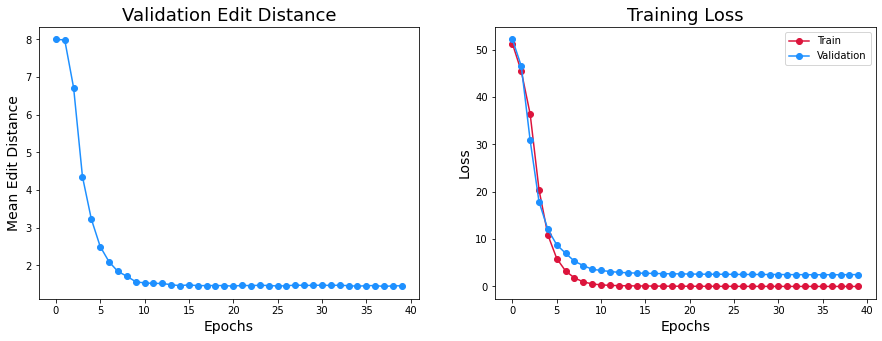

In [20]:
print('Fold', best_fold_idx, 'has the best loss:', best_loss)
plot_training_results(best_history, best_edist_log, 'CRNN.png')
best_model.save('CRNN.h5')

# Inference

In [21]:
from tensorflow.keras.models import Model, load_model
from ctc import CTCLayer, decode_batch_predictions

## Reload the model

In [23]:
reloaded_model = load_model('CRNN.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary(line_length=100)

Model: "Model_8"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                          

## On test dataset

Batch 1: ['㐌迻典畧\U000f0607公', '㗂寃㐌悶拍𡗶呌𨖲', '㗂𬷤𦖑㐌嘅催𠃅牆', '㝵𡢐別固﨤堆庒\U000f047c', '㤕臺隻𦲿𠀧爲', '丕𡢐𠦳淡登程買安', '丿兜㐌細府堂', '乘機娘買盤𦋦吶𠓨', '事兜渚急堆囬', '雲仙䀡𧡊卞𪟽衝𢚸', '雲仙䜹訴每塘𧵆賖', '雲仙畧㐌約麻', '雲仙苦浽爫清', '仍啉呂浽渃𡽫朱耒', '仕𦖑世賊㐌散', '仙明𠄩馭阻𦋦']

Batch 2: ['仙浪衝濁渚詳', '低它併特𠬠塘叱咍', '佛前産固每圖金銀', '信霜噸𠰺賒𧵆㖔𡁞', '倍鐄芇及併𧵆併賒', '倍𧗱所準園花', '催催妾㐌負払自低', '催時浽\U000f000e𡢐尼㐌㛪', '傷𢚸𡥵𥘷䜹癡', '儈頭納𫴋𡑝枚\U000f070b朝', '公浪庒𢪀役茄', '公浪\U000f0586𩈘𠄩昆', '六公欺𧘇買信事情', '六公𢖵細俸連哭嘆', '共妑武后調連細低', '內傷外感投湯五柴']

Batch 3: ['衝車質合苦無', '衝軍碎𠳨少之𩯀絲', '衝𧯄畧乙𡢐囂', '衝𨉓領𭛣公侯', '決𠳒𢴑襖𦋦𠫾', '決𢚸𠖈準黃泉﨤饒', '分蒲自院𫳘從', '別信自意旦𫢩', '別牢﨤特雲仙𣇜尼', '包除歇𣅶災𮥷', '包𣇞𨑮萬星兵', '化\U000f047e爫卦遊𩲉', '半命奴沛尋塘救吒', '廚兜𬂙體裊車', '雙雙𠓨畧𡑝花禮跪', '雙陀過典管之特身']



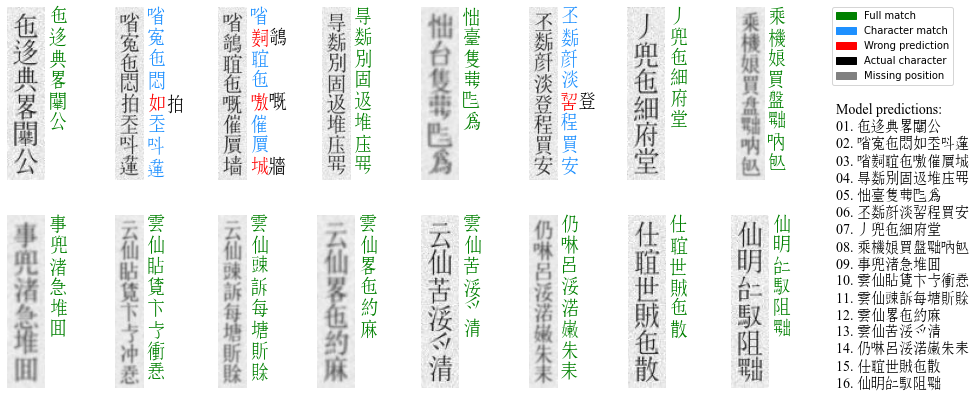

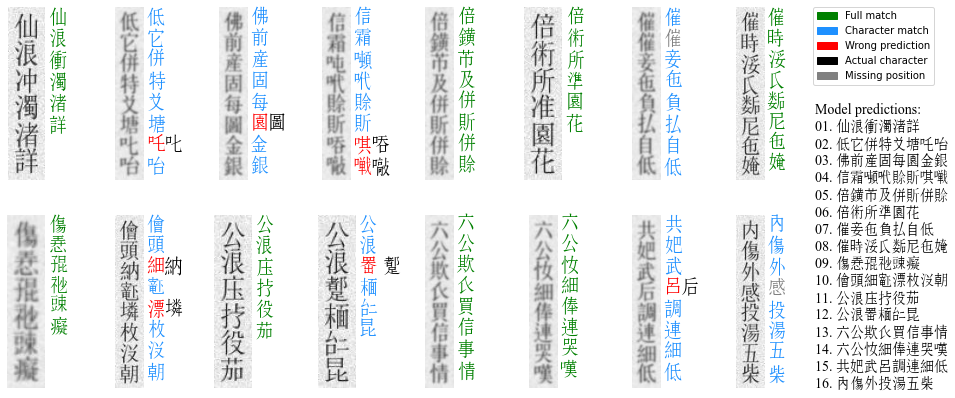

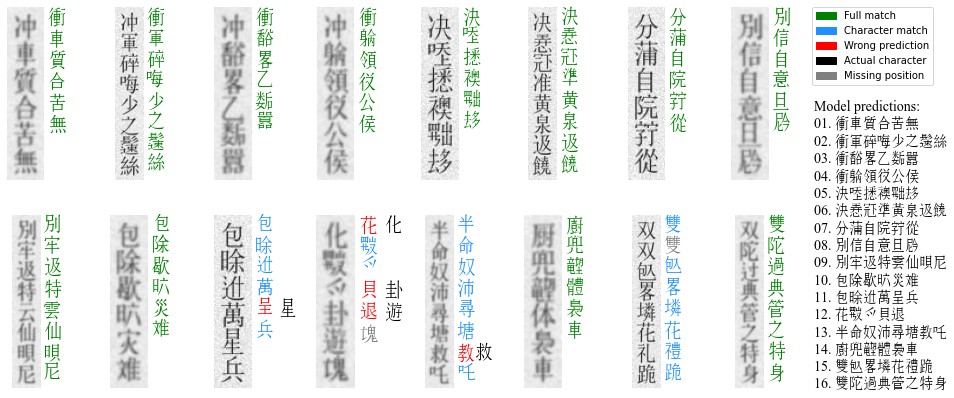

In [24]:
valid_dataset, valid_idxs = best_valid_dataset
for idx, batch in enumerate(valid_dataset.take(3)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels_in_batch = []
    
    for label in batch['label']:
        # Gather indices where label != padding_token.
        not_padding = tf.math.not_equal(label, PADDING_TOKEN)
        indices = tf.gather(label, tf.where(not_padding))
        label = tf.strings.reduce_join(num2char(indices)) # Convert to string
        labels_in_batch.append(label.numpy().decode('utf-8'))
        
    preds = reloaded_prediction_model.predict(batch['image'])
    pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
    visualize_images_labels(
        img_paths = img_paths[idxs_in_batch], 
        labels = labels_in_batch, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 # Position of actual label to plot
    )
    print(f'Batch {idx + 1}: {labels_in_batch}\n')

## On random image

In [25]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = process_images_labels(random_path, random_label)
batch_images = tf.expand_dims(random_image['image'], axis=0)

Predicted text: 大越史記金書


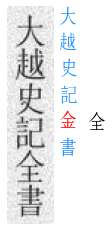

In [26]:
preds = reloaded_prediction_model.predict(batch_images)
pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))